In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import pandas as pd
import numpy as np
import sklearn.datasets
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as pyplot

# Dataset

In [2]:
def createdataset(n):
    x, y = make_moons(n_samples=n, noise=0.1)
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=1)
    y_train = y_train.reshape(1, y_train.shape[0])
    y_test = y_test.reshape(1, y_test.shape[0])
    return X_train, X_test, y_train, y_test

# Model

In [3]:
class NN2Layer():
    
    def __init__(self, data, label, hidden_n, lr, iteration, threshold, activationH, activationO,batch, lrType=False, lrmultiple=1,
                 momentum=False, delfactor=0):
        #parameters
        self.hiddenSize = hidden_n
        self.X = data
        self.Y = label
        self.iteration = iteration
        self.lr = lr
        self.batch = batch
        self.threshold = threshold
        self.activation_h = self.activactionFunction[activationH]
        self.activation_O = self.activactionFunction[activationO]
        self.deractivation_h =  self.derAivationFunction[activationH]
        self.lrM = lrmultiple

        self.lrType = lrType
        self.alg = momentum
        self.delayFactor = delfactor
        
        self.prevW1 = 0
        self.prevW2 = 0
        self.prevb1 = 0
        self.prevb2 = 0

    activactionFunction = {
         'sigmoid': (lambda x: 1/(1 + np.exp(-x))),
            'tanh': (lambda x: np.tanh(x)),
            'Relu': (lambda x: x*(x > 0)),
        'identical': (lambda x: x),
         'softmax': (lambda x : np.exp(x) / sum(np.exp(x))),
               }
    derAivationFunction = {
         'sigmoid': (lambda x: x*(1-x)),
            'tanh': (lambda x: 1-x**2),
            'Relu': (lambda x: 1 * (x>0)),
        'identical': (lambda x: 1),
               }
        
    def get_accuracy(self,target, predictions):

        count = 0
        for i in range(len(target[0])):
            if(predictions[0][i]>0.5):
                if(1==target[0][i]):
                    count+=1
            else:
                if(0==target[0][i]):
                    count+=1
        return count / target.size

    def forwardPropagation(self, params, x):
        
        Z1 = np.dot(params['W1'], x.T)+params['b1']
        A1 = self.activation_h(Z1)
        Z2 = np.dot(params['W2'], A1)+params['b2']
        y = self.activation_O(Z2) 
        return y, {'Z1': Z1, 'Z2': Z2, 'A1': A1, 'y': y}
    
    def backPropagation(self,x,targety, params, cache, ltype=False, index=0):

        m = self.batch
        dy = cache['y'] - targety

        dW2 = (1 / m) * np.dot(dy, np.transpose(cache['A1']))
        db2 = (1 / m) * np.sum(dy, axis=1, keepdims=True)
        dZ1 = np.dot(np.transpose(params['W2']), dy) * (self.deractivation_h(cache['A1']))
        dW1 = (1 / m) * np.dot(dZ1, x)
        db1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)
        
        return {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}

    def setParameters(self):
    
        np.random.seed(3)
        input_size = self.X.shape[1]
        output_size = self.Y.shape[0] 
        W1 = np.random.randn(self.hiddenSize, input_size)
        b1 = np.zeros((self.hiddenSize, 1))
        W2 = np.random.randn(output_size, self.hiddenSize)
        b2 = np.zeros((output_size, 1))
        
        return {'W1': W1, 'W2': W2, 'b1': b1, 'b2': b2}
    
    def costf(self,predict, targety):

        cost = np.square(np.subtract(targety,predict)).mean()

        return cost

    def updateParameters(self, gradients, params):

        if(self.alg == True):
            self.prevW1 = self.delayFactor*self.prevW1 - self.lr * gradients['dW1']
            self.prevW2 = self.delayFactor*self.prevW2 - self.lr * gradients['dW2']
            self.prevb1 = self.delayFactor*self.prevb1 - self.lr * gradients['db1']
            self.prevb2 = self.delayFactor*self.prevb2 - self.lr * gradients['db2']

            W1 = params['W1'] + self.prevW1
            b1 = params['b1'] + self.prevb1
            W2 = params['W2'] + self.prevW2
            b2 = params['b2'] + self.prevb2
        else:
            W1 = params['W1'] - self.lr * gradients['dW1']
            b1 = params['b1'] - self.lr * gradients['db1']
            W2 = params['W2'] - self.lr * gradients['dW2']
            b2 = params['b2'] - self.lr * gradients['db2']
        return {'W1': W1, 'W2': W2, 'b1': b1, 'b2': b2}
            
    def fit(self):
        
        params = self.setParameters()
        costvalue = []
        accValue = []
        
        for j in range(self.iteration):
            for i in range(0,self.X.shape[0], self.batch):

                batchData = self.X[i:i+self.batch]
                target = self.Y[0][i:i+self.batch]
                target = np.reshape(target,(1,target.shape[0]))
                
                y, cache = self.forwardPropagation(params, batchData)
                gradients = self.backPropagation(batchData,target, params, cache)
                params = self.updateParameters(gradients, params)
                
                accValue.append(self.get_accuracy(target,cache['y']))

            eva, tempcache = self.forwardPropagation(params, self.X)
            costval = self.costf(eva, self.Y)
            costvalue.append(costval)
            if(costval<= self.threshold): return params, {"err": costvalue, "acc":accValue}
            if(self.lrType==True):
                self.lr = self.lrM *self.lr
        
        return params, {"err": costvalue, "acc":accValue}

In [4]:
class test():
    
    def __init__(self, data, label, param, activationH, activationO):

        self.X = data
        self.Y = label
        self.params = param
        self.activation_h = self.activactionFunction[activationH]
        self.activation_O = self.activactionFunction[activationO]

    activactionFunction = {
         'sigmoid': (lambda x: 1/(1 + np.exp(-x))),
            'tanh': (lambda x: np.tanh(x)),
            'Relu': (lambda x: x*(x > 0)),
        'identical': (lambda x: x),
         'softmax': (lambda x : np.exp(x) / sum(np.exp(x))),
               }
    def get_predict(self, predictions):

        predict = []
        for i in range(predictions.shape[1]):
            if(predictions[0][i]>0.5):
                predict.append(1)
            else:
                predict.append(0)
        return predict
    
    def get_accuracy(self, predictions):
        count = 0
        predict = []
        for i in range(len(self.Y[0])):
            if(predictions[0][i]>0.5):
                if(1==self.Y[0][i]):
                    predict.append(1)
                    count+=1
                else:
                    predict.append(1)
            else:
                if(0==self.Y[0][i]):
                    count+=1
                    predict.append(0)
                else:
                    predict.append(0)

        vv =count / self.Y.size
#         print("predict: ",len(predict))
        return {"acc": vv, "pred":predict}

    def forwardPropagation(self):
        Z1 = np.dot(self.params['W1'], self.X.T) + self.params['b1']
        A1 = self.activation_h(Z1)
        Z2 = np.dot(self.params['W2'], A1) + self.params['b2']
        y = self.activation_O(Z2)
        return y
            
    def fit(self):
        y = self.forwardPropagation()
#         a = self.get_accuracy(cache['y'])
#         print("Accuracy: ", a['acc'] )
        return y

In [5]:
def visualize_classifier(x, y, parameters):
    h = .02 
    x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h))
    
    x_plt = np.c_[xx.ravel(), yy.ravel()]

#     print("xx.shape: ",xx.shape)
#     print("x_plt.shape: ",x_plt.shape)
#     print(yy.ravel())
    testmodel = test(x_plt,x_plt, parameters, "tanh", "sigmoid")

    per = testmodel.fit()
    Z = testmodel.get_predict(per)
#     print(x_plt.shape)
#     print(Z['pred'].shape)
    Z = np.array(Z)
#     print("q4: ",q.shape)

    Z = Z.reshape(xx.shape)
#     print("q: ",Z.shape)
    
    pyplot.contourf(xx,yy,Z,cmap=pyplot.cm.coolwarm, alpha=0.8)
    pyplot.scatter(x[:,0],x[:,1],c=y)
    pyplot.show()

# Create Dataset


In [6]:
n = 1000
X_train, X_test, y_train, y_test = createdataset(n)

# Train and Test
learing rate type = constant

learnig type =  batch

activation function = sigmoid

In [7]:
model = NN2Layer(X_train, y_train, 10, 0.3, 7000, 0.001, "sigmoid", "sigmoid",n)
params, value = model.fit()

In [8]:
params

{'W1': array([[ 8.3783507 ,  2.46527182],
        [ 1.08351766, -1.40233801],
        [ 1.13877315, -1.27155268],
        [ 1.02459987, -1.16114368],
        [-1.03696811,  1.02621825],
        [-1.28386213,  1.49094201],
        [ 1.25296943,  1.39308077],
        [ 1.02080819, -0.76707946],
        [-1.1734822 , -0.93877169],
        [ 1.04138789, -1.27690664]]),
 'W2': array([[-11.34932865,   4.05973628,   5.19073988,   3.5476734 ,
          -3.49719618,  -4.86991712,   0.71468446,   2.13464641,
          -0.96062054,   3.89285585]]),
 'b1': array([[-4.72343833],
        [ 0.35095224],
        [ 0.45511909],
        [-0.20784983],
        [ 0.36810425],
        [ 1.29651981],
        [-0.05835331],
        [-0.11460795],
        [-0.18867359],
        [-0.46024316]]),
 'b2': array([[0.1471329]])}

In [9]:
testmodel = test(X_test, y_test, params, "sigmoid", "sigmoid")
per = testmodel.fit()
result = testmodel.get_accuracy(per)
print("Accuracy: ", result['acc'])

Accuracy:  0.98


In [10]:
#Momentum
model = NN2Layer(X_train, y_train, 10, 0.3, 7000, 0.001, "sigmoid", "sigmoid",n, False, 0, True, 0.029)
paramsm, valuem = model.fit()

testmodel = test(X_test, y_test, paramsm, "sigmoid", "sigmoid")
perm = testmodel.fit()
resultm = testmodel.get_accuracy(perm)
print("Momentum Accuracy: ", resultm['acc'])

Momentum Accuracy:  0.98


([<matplotlib.lines.Line2D at 0x11a598a0ee0>],
 [<matplotlib.lines.Line2D at 0x11a598b32e0>])

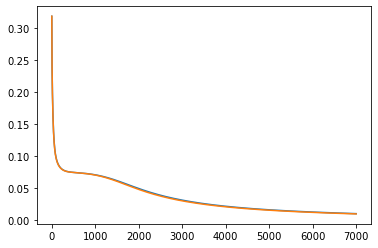

In [11]:
plt.plot(value['err']), plt.plot(valuem['err'])

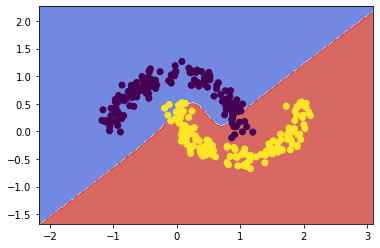

In [12]:
visualize_classifier(X_test, y_test, params)

learing rate type = constant

learnig type =  online

activation function = sigmoid

In [13]:
model = NN2Layer(X_train, y_train, 10, 0.01, 100, 0.001, "sigmoid", "sigmoid",1)
params, value = model.fit()

In [14]:
params

{'W1': array([[ 6.50624908,  1.39833387],
        [ 1.01112226, -1.94742543],
        [ 1.03245887, -1.68267156],
        [ 0.96964994, -1.29846255],
        [-0.98586557,  0.96559643],
        [-1.00859519,  1.76213586],
        [ 1.19349441,  1.53728784],
        [ 0.65864958, -0.56694198],
        [-0.95773961, -1.16654836],
        [ 0.98673919, -1.57290453]]),
 'W2': array([[-6.7855024 ,  2.8478298 ,  3.93424331,  2.28646923, -2.46109932,
         -3.74841843,  0.1181237 ,  0.9094033 , -0.47112452,  2.63865338]]),
 'b1': array([[-3.41226926],
        [ 0.20064456],
        [ 0.24579244],
        [-0.03096668],
        [ 0.08113865],
        [ 0.18841239],
        [-0.17225914],
        [-0.03194492],
        [-0.13736883],
        [-0.11210841]]),
 'b2': array([[-0.07552669]])}

In [15]:
testmodel = test(X_test, y_test, params, "sigmoid", "sigmoid")
per = testmodel.fit()
result = testmodel.get_accuracy(per)
print("Accuracy: ", result['acc'])

Accuracy:  0.9533333333333334


In [16]:
#Momentum
model = NN2Layer(X_train, y_train,10, 0.01, 100, 0.001, "sigmoid", "sigmoid",1, False, 0, True, 0.029)
paramsm, valuem = model.fit()

testmodel = test(X_test, y_test, paramsm, "sigmoid", "sigmoid")
perm = testmodel.fit()
resultm = testmodel.get_accuracy(perm)
print("Momentum Accuracy: ", resultm['acc'])

Momentum Accuracy:  0.9566666666666667


([<matplotlib.lines.Line2D at 0x11a59e1efd0>],
 [<matplotlib.lines.Line2D at 0x11a597f43a0>])

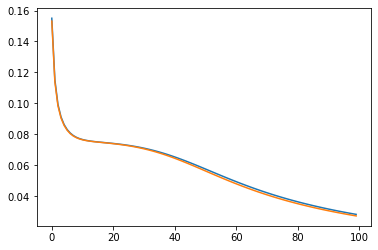

In [17]:
plt.plot(value['err']),plt.plot(valuem['err'])

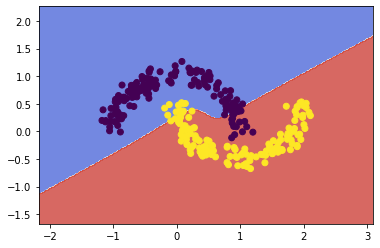

In [18]:
visualize_classifier(X_test, y_test, params)

learing rate type = constant

learnig type =  online

activation function = tanh

In [19]:
model = NN2Layer(X_train, y_train, 5, 0.01, 100, 0.001, "tanh", "sigmoid",1)
params, value = model.fit()

In [20]:
params

{'W1': array([[ 4.19059578,  2.36658603],
        [ 2.21658234, -1.48014575],
        [ 0.88771905, -0.74891731],
        [ 2.71564128, -1.7916525 ],
        [ 0.53916296, -0.55757916]]),
 'W2': array([[-6.52195791,  4.28867456,  3.08297752,  5.11690568,  2.06112962]]),
 'b1': array([[-2.69227446],
        [-2.82646396],
        [-1.03242993],
        [ 1.7376804 ],
        [ 0.14861151]]),
 'b2': array([[0.28082858]])}

In [21]:
testmodel = test(X_test, y_test, params, "tanh", "sigmoid")
per = testmodel.fit()
result = testmodel.get_accuracy(per)
print("Accuracy: ", result['acc'])

Accuracy:  1.0


In [22]:
#Momentum
model = NN2Layer(X_train, y_train, 5, 0.01, 100, 0.001, "tanh", "sigmoid",1, False, 0, True, 0.029)
paramsm, valuem = model.fit()

testmodel = test(X_test, y_test, paramsm, "tanh", "sigmoid")
perm = testmodel.fit()
resultm = testmodel.get_accuracy(perm)
print("Momentum Accuracy: ", resultm['acc'])

Momentum Accuracy:  1.0


([<matplotlib.lines.Line2D at 0x11a59df17c0>],
 [<matplotlib.lines.Line2D at 0x11a59df1b50>])

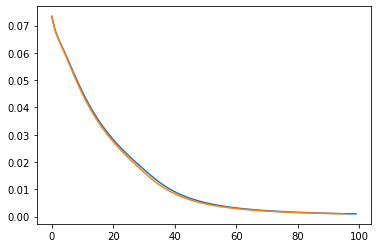

In [23]:
plt.plot(value['err']),plt.plot(valuem['err'])

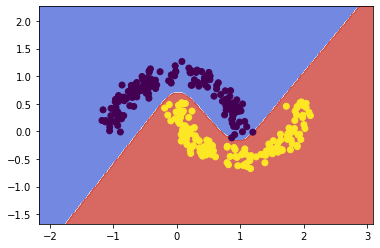

In [24]:
visualize_classifier(X_test, y_test, params)

learing rate type = constant

learnig type =  batch

activation function = tanh

In [25]:
model = NN2Layer(X_train, y_train, 5, 0.3, 7000, 0.001, "tanh", "sigmoid",n)
params, value = model.fit()

In [26]:
params

{'W1': array([[ 4.40300001,  2.48648672],
        [ 2.04705448, -1.34004051],
        [ 0.71095017, -0.59458235],
        [ 2.38490397, -1.5362448 ],
        [ 0.53070061, -0.52968813]]),
 'W2': array([[-7.20742049,  4.60800695,  3.63430605,  5.28596324,  2.5711356 ]]),
 'b1': array([[-2.82516376],
        [-2.61511443],
        [-0.7109071 ],
        [ 1.51331063],
        [ 0.09277627]]),
 'b2': array([[0.14725536]])}

In [27]:
testmodel = test(X_test, y_test, params, "tanh", "sigmoid")
per = testmodel.fit()
result = testmodel.get_accuracy(per)
print("Accuracy: ", result['acc'])

Accuracy:  1.0


In [28]:
#Momentum
model = NN2Layer(X_train, y_train, 5, 0.3, 7000, 0.001, "tanh", "sigmoid",n, False, 0, True, 0.029)
paramsm, valuem = model.fit()

testmodel = test(X_test, y_test, paramsm, "tanh", "sigmoid")
perm = testmodel.fit()
resultm = testmodel.get_accuracy(perm)
print("Momentum Accuracy: ", resultm['acc'])

Momentum Accuracy:  1.0


([<matplotlib.lines.Line2D at 0x11a59be1b20>],
 [<matplotlib.lines.Line2D at 0x11a59be1eb0>])

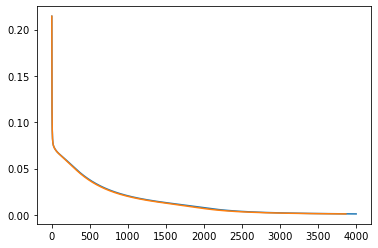

In [29]:
plt.plot(value['err']),plt.plot(valuem['err'])

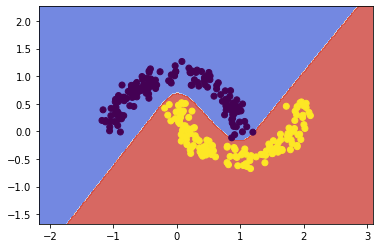

In [30]:
visualize_classifier(X_test, y_test, params)

learing rate type = variable

learnig type =  batch

activation function = sigmoid

In [31]:
model = NN2Layer(X_train, y_train, 15, 0.8, 5000, 0.001, "sigmoid", "sigmoid",n, True, 0.2)
params, value = model.fit()

In [32]:
params

{'W1': array([[ 1.80478989,  0.43112499],
        [ 0.21778384, -1.87951073],
        [-0.35770369, -0.34106016],
        [-0.12419461, -0.62037076],
        [-0.0976232 , -0.46865164],
        [-1.37797241,  0.89850112],
        [ 0.83750247,  1.72043625],
        [-0.01876109, -0.39383813],
        [-0.48005321, -1.55978634],
        [ 0.97817524, -1.1004465 ],
        [-1.24083028, -0.19126878],
        [ 1.5038237 ,  0.23143918],
        [-1.03833616, -0.70932882],
        [ 0.53106675, -0.14330706],
        [-0.79786872, -0.22395078]]),
 'W2': array([[ 0.96067126,  2.14095086, -1.12181405, -0.48752294, -0.66404606,
         -2.35599056, -0.75268194, -0.87876429,  1.24553322,  0.07166477,
         -1.54814505,  0.85660182, -0.26949335, -1.56477621, -0.5035352 ]]),
 'b1': array([[ 0.03050998],
        [ 0.12291943],
        [-0.08280009],
        [-0.04181283],
        [-0.05418121],
        [-0.0984416 ],
        [-0.05241467],
        [-0.06921768],
        [ 0.07142601],
        

In [33]:
testmodel = test(X_test, y_test, params, "sigmoid", "sigmoid")
per = testmodel.fit()
result = testmodel.get_accuracy(per)
print("Accuracy: ", result['acc'])

Accuracy:  0.7366666666666667


In [34]:
#Momentum
model = NN2Layer(X_train, y_train,  15, 0.8, 5000, 0.001, "sigmoid", "sigmoid",n, True, 0.2, True, 0.029)
paramsm, valuem = model.fit()

testmodel = test(X_test, y_test, paramsm, "sigmoid", "sigmoid")
perm = testmodel.fit()
resultm = testmodel.get_accuracy(perm)
print("Momentum Accuracy: ", resultm['acc'])

Momentum Accuracy:  0.74


([<matplotlib.lines.Line2D at 0x11a59e95df0>],
 [<matplotlib.lines.Line2D at 0x11a59ae41c0>])

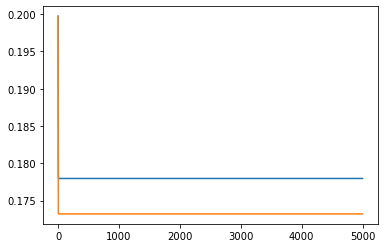

In [35]:
plt.plot(value['err']),plt.plot(valuem['err'])

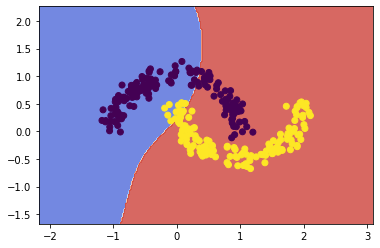

In [36]:
visualize_classifier(X_test, y_test, params)

learing rate type = variable

learnig type =  online

activation function = sigmoid

In [37]:
model = NN2Layer(X_train, y_train, 15, 0.3, 100, 0.001, "sigmoid", "sigmoid",1, True, 0.2)
params, value = model.fit()

In [38]:
params

{'W1': array([[ 1.0212268 , -0.1836862 ],
        [ 0.67105593, -3.06913624],
        [-0.66453233,  0.33035325],
        [-0.42264425, -0.51906357],
        [-0.47312658, -0.20094845],
        [-0.8315893 ,  2.30402777],
        [ 1.47692748,  2.16357051],
        [-0.49905474,  0.04242472],
        [-1.01888763, -2.45334137],
        [ 0.5958069 , -1.59692443],
        [-0.79226853,  0.79124391],
        [ 0.68895098, -0.53918571],
        [-1.15853183, -0.69842129],
        [-0.36282648,  0.776327  ],
        [-0.80328771,  0.05155731]]),
 'W2': array([[ 0.69119028,  3.02134419, -0.93969201, -0.07036967, -0.3402756 ,
         -2.73442682, -1.59346765, -0.58407284,  2.05255243,  1.07321494,
         -1.43073756,  0.89442578,  0.2300759 , -1.19023721, -0.40769352]]),
 'b1': array([[ 0.08072664],
        [ 0.09598966],
        [-0.45474497],
        [-0.35164457],
        [-0.39086941],
        [-0.45094191],
        [-0.84985016],
        [-0.43397837],
        [ 0.35108646],
        

In [39]:
testmodel = test(X_test, y_test, params, "sigmoid", "sigmoid")
per = testmodel.fit()
result = testmodel.get_accuracy(per)
print("Accuracy: ", result['acc'])

Accuracy:  0.8966666666666666


In [40]:
#Momentum
model = NN2Layer(X_train, y_train,  15, 0.3, 100, 0.001, "sigmoid", "sigmoid",1, True, 0.2, True, 0.029)
paramsm, valuem = model.fit()

testmodel = test(X_test, y_test, paramsm, "sigmoid", "sigmoid")
perm = testmodel.fit()
resultm = testmodel.get_accuracy(perm)
print("Momentum Accuracy: ", resultm['acc'])

Momentum Accuracy:  0.8966666666666666


([<matplotlib.lines.Line2D at 0x11a59addd00>],
 [<matplotlib.lines.Line2D at 0x11a59caa0d0>])

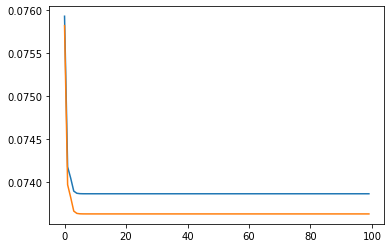

In [41]:
plt.plot(value['err']),plt.plot(valuem['err'])

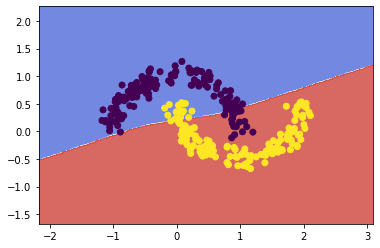

In [42]:
visualize_classifier(X_test, y_test, params)

learing rate type = variable

learnig type =  batch

activation function = tanh

In [43]:
model = NN2Layer(X_train, y_train, 15, 0.85, 5000, 0.001, "tanh", "sigmoid",n, True, 0.4)
params, value = model.fit()

In [44]:
params

{'W1': array([[ 1.78127491,  0.43406739],
        [ 0.00803037, -1.88990933],
        [-0.18992818, -0.30053185],
        [-0.03980918, -0.60204853],
        [ 0.0151568 , -0.44081764],
        [-1.17149304,  0.98100559],
        [ 0.89694271,  1.70980692],
        [ 0.12928682, -0.35466896],
        [-0.57917354, -1.55362562],
        [ 0.99230663, -1.09528415],
        [-1.13053451, -0.17312051],
        [ 1.47298824,  0.22906873],
        [-1.01439773, -0.70911834],
        [ 0.74844248, -0.08293017],
        [-0.7371805 , -0.21122556]]),
 'W2': array([[ 0.64852864,  2.0334702 , -1.20645455, -0.59040306, -0.77713296,
         -2.36634781, -1.01067758, -1.00803077,  1.202541  , -0.15597076,
         -1.54115748,  0.55588845, -0.27112204, -1.78538864, -0.53178372]]),
 'b1': array([[ 0.02652279],
        [-0.02428238],
        [ 0.05581168],
        [ 0.0269873 ],
        [ 0.04025703],
        [ 0.06555019],
        [-0.02707751],
        [ 0.05640255],
        [ 0.01457707],
        

In [45]:
testmodel = test(X_test, y_test, params, "tanh", "sigmoid")
per = testmodel.fit()
result = testmodel.get_accuracy(per)
print("Accuracy: ", result['acc'])

Accuracy:  0.8366666666666667


In [46]:
#Momentum
model = NN2Layer(X_train, y_train, 15, 0.85, 5000, 0.001, "tanh", "sigmoid",n, True, 0.4, True, 0.029)
paramsm, valuem = model.fit()

testmodel = test(X_test, y_test, paramsm, "tanh", "sigmoid")
perm = testmodel.fit()
resultm = testmodel.get_accuracy(perm)
print("Momentum Accuracy: ", resultm['acc'])

Momentum Accuracy:  0.8366666666666667


([<matplotlib.lines.Line2D at 0x11a59f84640>],
 [<matplotlib.lines.Line2D at 0x11a59f849d0>])

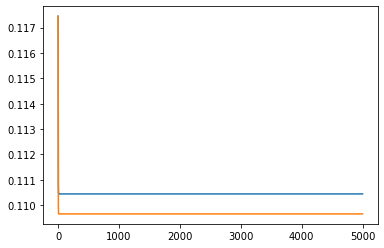

In [47]:
plt.plot(value['err']),plt.plot(valuem['err'])

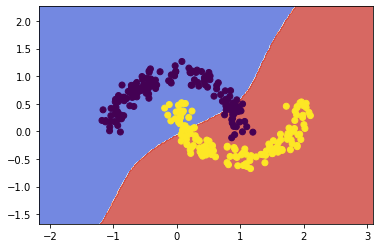

In [48]:
visualize_classifier(X_test, y_test, params)

learing rate type = variable

learnig type =  online

activation function = tanh

In [49]:
model = NN2Layer(X_train, y_train, 20, 0.85, 100, 0.001, "tanh", "sigmoid",1, True, 0.3)
params, value = model.fit()

In [50]:
params

{'W1': array([[ 4.62308244,  2.64172142],
        [ 1.69634202, -5.65582371],
        [-0.14147685,  0.25422163],
        [-4.77958321,  2.71831651],
        [-0.14338788,  0.11993432],
        [-0.77622448,  3.14330771],
        [-1.35042333,  4.15135679],
        [ 0.58947584, -1.08477162],
        [-3.34196794,  0.81335699],
        [ 0.64561734, -4.37686784],
        [ 0.14850271, -0.3416624 ],
        [ 5.41233201, -1.60045743],
        [ 0.83660156, -2.38538638],
        [ 0.38648516, -3.26129928],
        [ 1.79112506, -3.41107952],
        [-3.29199825,  4.39339326],
        [ 0.54217424, -1.01722091],
        [-6.00089245, -2.22262737],
        [ 0.30541409, -0.66763575],
        [-0.61018895,  1.24587587]]),
 'W2': array([[-2.93855473,  1.81871251, -0.10583675, -3.5431605 , -0.09815771,
         -0.67115215, -0.31284819,  0.44628704, -1.53550182,  1.06634525,
          0.1167557 ,  4.50257288,  0.12896855, -0.16996864,  1.4461992 ,
         -2.70835807,  0.40508154,  4.396286

In [51]:
testmodel = test(X_test, y_test, params, "tanh", "sigmoid")
per = testmodel.fit()
result = testmodel.get_accuracy(per)
print("Accuracy: ", result['acc'])

Accuracy:  1.0


In [52]:
#Momentum
model = NN2Layer(X_train, y_train, 20, 0.85, 100, 0.001, "tanh", "sigmoid",1, True, 0.3, True, 0.029)
paramsm, valuem = model.fit()

testmodel = test(X_test, y_test, paramsm, "tanh", "sigmoid")
perm = testmodel.fit()
resultm = testmodel.get_accuracy(perm)
print("Momentum Accuracy: ", resultm['acc'])

Momentum Accuracy:  0.9966666666666667


([<matplotlib.lines.Line2D at 0x11a59a64160>],
 [<matplotlib.lines.Line2D at 0x11a59a64be0>])

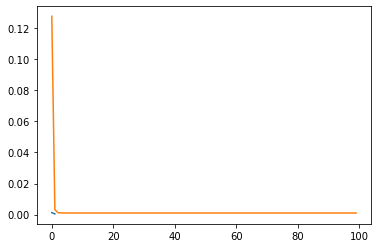

In [53]:
plt.plot(value['err']),plt.plot(valuem['err'])

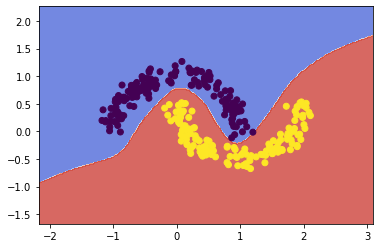

In [54]:
visualize_classifier(X_test, y_test, params)